In [130]:
%load_ext autoreload
%autoreload 2
from paths import *
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.utils
import torch.distributions
import numpy as np
import dill
from tqdm import tqdm
from datetime import date
import os, sys
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib
from IPython.display import Image, display, clear_output
from scipy import stats
from src.SERS_dataset import IterDataset, SERSDataset, SERSDatasetNPY
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.models.vanilla_VAE import VariationalAutoencoder
from torch import Tensor
from src.plotting.VAE_plotting import *

# Matplot lib style
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_21516\1340020209.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [28]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

def train(autoencoder, data, optimizer="SGD", epochs=30, num_iterations_per_epoch = None, lr = 0.001, beta=1, label = "alpha"):
    """ Train the autoencoder on the data for a number of epochs
    
    Args:
        autoencoder (nn.Module): The autoencoder to train
        data (DataLoader): The data to train on
        epochs (int): The number of epochs to train for

    Returns:
        nn.Module: The trained autoencoder
    """

    # The optimizer is defined 
    if optimizer == 'adam':
        opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    else: 
        opt = torch.optim.SGD(autoencoder.parameters(), lr=lr)

    # The loss function is defined
    loss_function = nn.MSELoss()

    # Lists to store the loss values
    train_loss = []
    train_loss_kl = []
    train_loss_elbo = []
    train_loss_logpx = []

    # Loop through epochs 
    for epoch in range(epochs):
        batch_loss = []
        batch_loss_kl = []
        batch_elbo = []
        batch_logpx = []
      
        # Loop through batches of train data
        for i, (x, y) in enumerate(data):
            x = x.to(device)
            opt.zero_grad()
            z, mu, logvar = autoencoder.encode(x)
            x_hat = autoencoder.decode(z)

            px = autoencoder.px
            pz = autoencoder.pz
            qz = autoencoder.qz

            # evaluate log probabilities
            log_px = reduce(px.log_prob(x))
            log_pz = reduce(pz.log_prob(z))
            log_qz = reduce(qz.log_prob(z))
            
            kl = log_qz - log_pz
            elbo = log_px - kl
            beta_elbo = log_px - beta * kl
            
            # loss
            loss = -beta_elbo.mean()
        
            loss.backward()
            opt.step()

            batch_loss.append(loss.mean().item())
            batch_loss_kl.append(kl.mean().item())
            batch_elbo.append(elbo.mean().item())
            batch_logpx.append(log_px.mean().item())
            
            if num_iterations_per_epoch and i == num_iterations_per_epoch:
                break

        train_loss.append(np.mean(batch_loss))
        train_loss_kl.append(np.mean(batch_loss_kl))
        train_loss_elbo.append(np.mean(batch_elbo))
        train_loss_logpx.append(np.mean(batch_logpx))
         
        with torch.no_grad():
            autoencoder.eval()
            x, y = next(iter(data))
            x = x.to(device)
            z, mu, logvar = autoencoder.encode(x)
            x_hat = autoencoder.decode(z)
            x_hat_mu = autoencoder.decode(mu)
           
            ll = {"c": 0, "gamma": 1, "eta": 2, "alpha": 3}
            labels = []
            if isinstance(label, list):
                for l in label:
                    labels.append(y[:,ll[l]])
            else:
                labels.append(y[:,ll[label]])
                label = [label]

        if epoch % 10 == 0:
            plot_loss(epoch+1, epochs, train_loss, train_loss_kl, train_loss_elbo, train_loss_logpx,  z, x, x_hat, x_hat_mu, mu, logvar, labels, label)
    plot_loss(epochs, epochs, train_loss, train_loss_kl, train_loss_elbo, train_loss_logpx, z, x, x_hat, x_hat_mu, mu, logvar, labels, label)

    return autoencoder, train_loss

# Vary $\alpha$

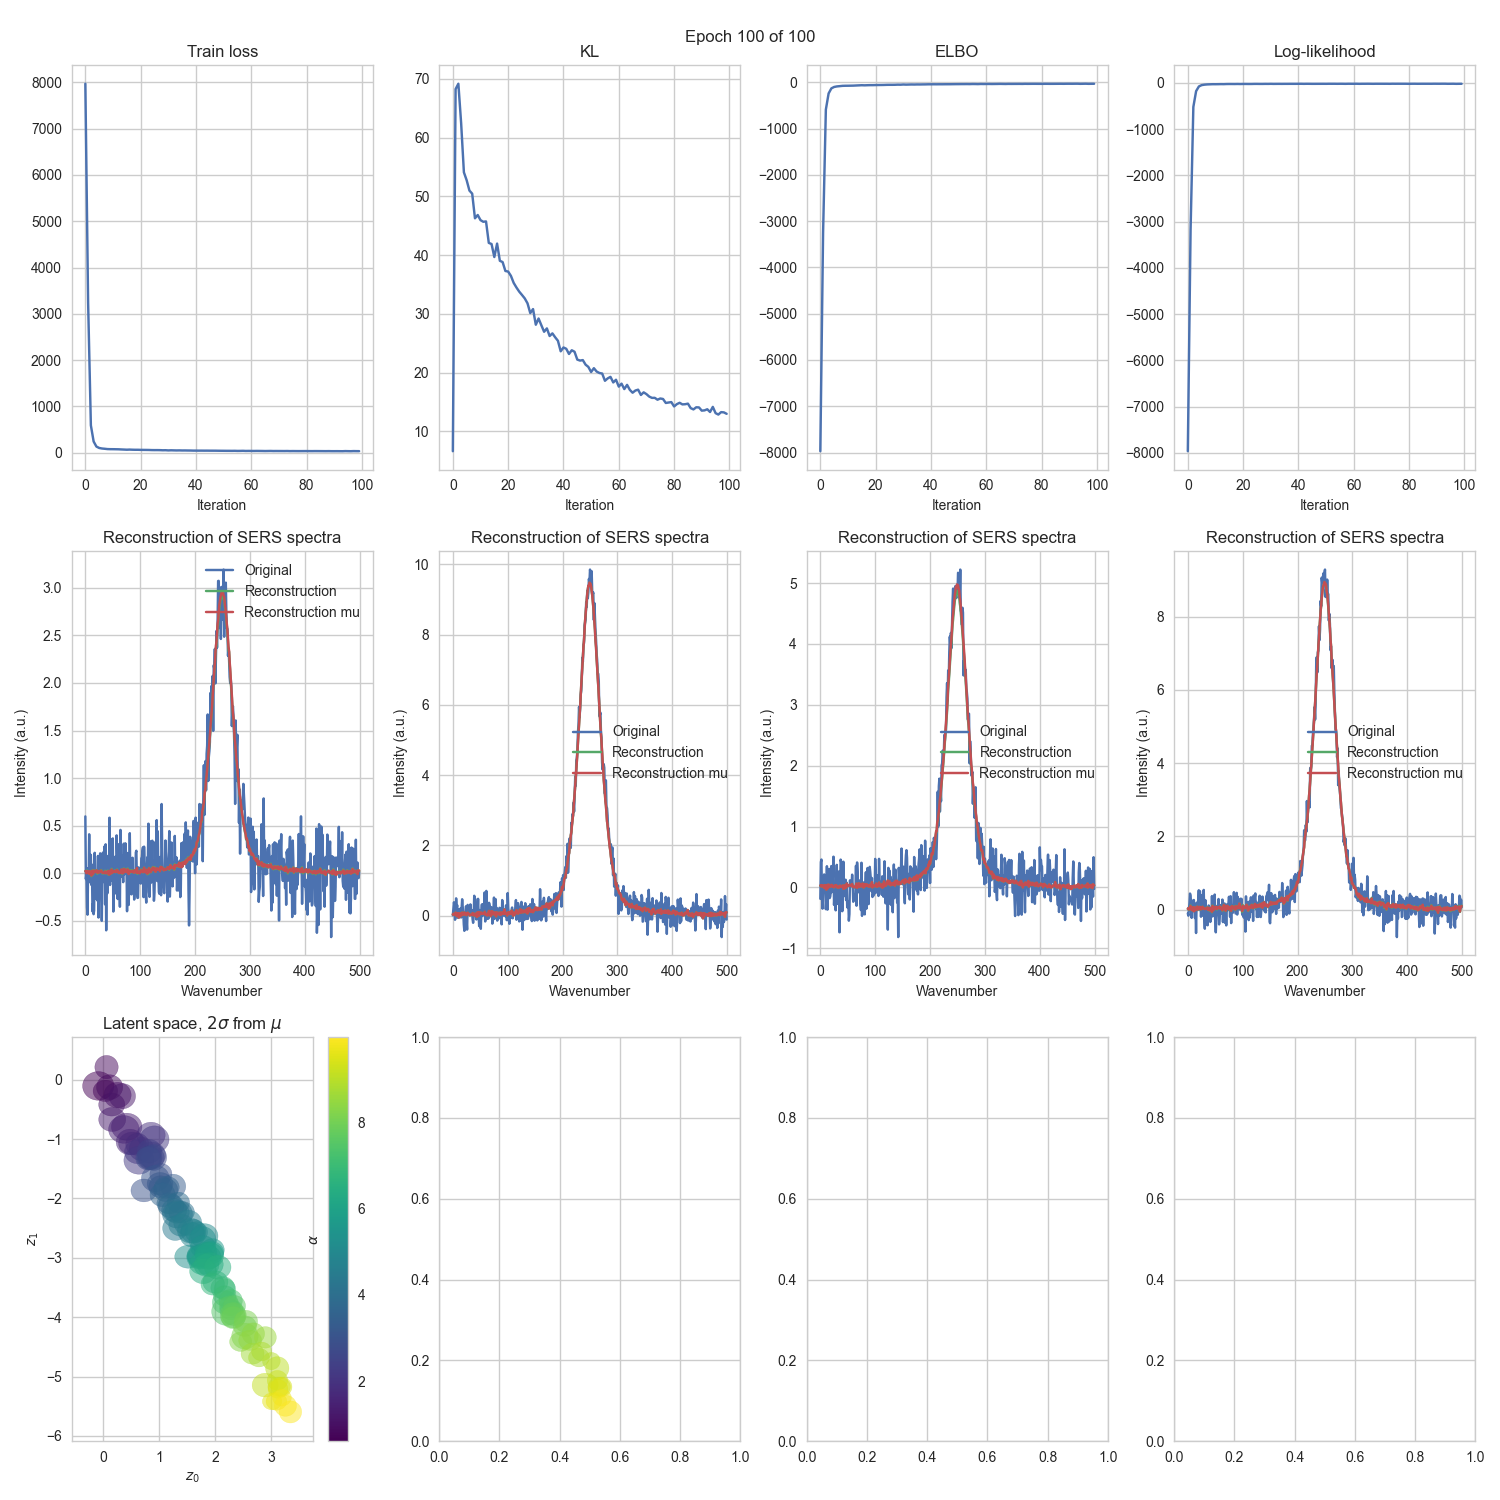

In [177]:
latent_dims = 2
epochs = 100
num_batches_per_epoch = 10
learning_rate = 1e-3
optimizer = "adam"
beta = 1


batch_size = 100
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = torch.tensor([250]), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = (0.5,10), sigma = 0.25)

dset_train = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)

autoencoder = VariationalAutoencoder(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, "alpha").to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label="alpha")


In [168]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
x_hat = autoencoder.decode(z)
x_hat_mu = autoencoder.decode(mu)
sigma = torch.exp(0.5*logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

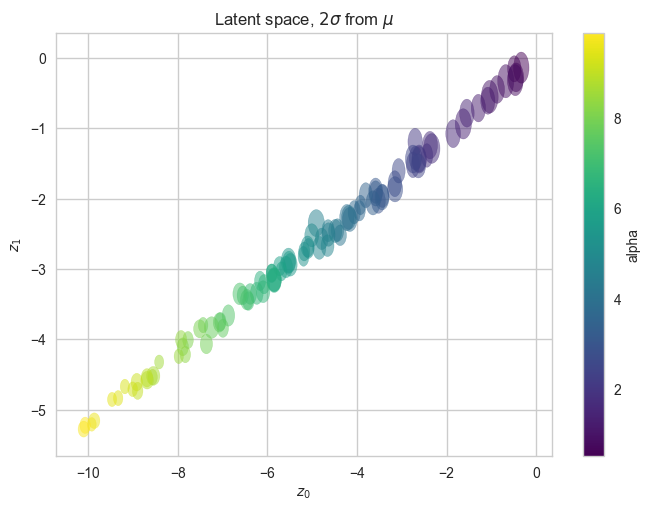

In [169]:
plt_latent_space_ellipses(z, mu, sigma, y[:,3].to('cpu').detach().numpy(), '$\\alpha$')

(100,) (100,)


Text(0, 0.5, 'sigma')

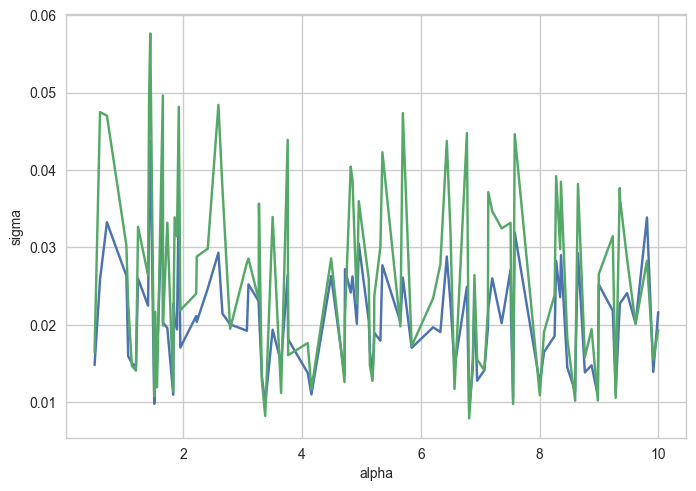

In [170]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
sigma = torch.exp(logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

alpha = y[:,3].to('cpu').detach().numpy()
alpha = alpha.flatten()
sort = np.argsort(alpha)
z = z[sort]
mu = mu[sort]
sigma1 = sigma[:,0].flatten()
sigma2 = sigma[:,1].flatten()
print(sigma1.shape, sigma2.shape)
sigma1 = sigma1[sort]
sigma2 = sigma2[sort]

y = y[sort]
alpha = alpha[sort]

# sigma[:,0]

plt.plot(alpha, sigma1, '-')
plt.plot(alpha, sigma2, '-')

# axes 
plt.xlabel('alpha')
plt.ylabel('sigma')


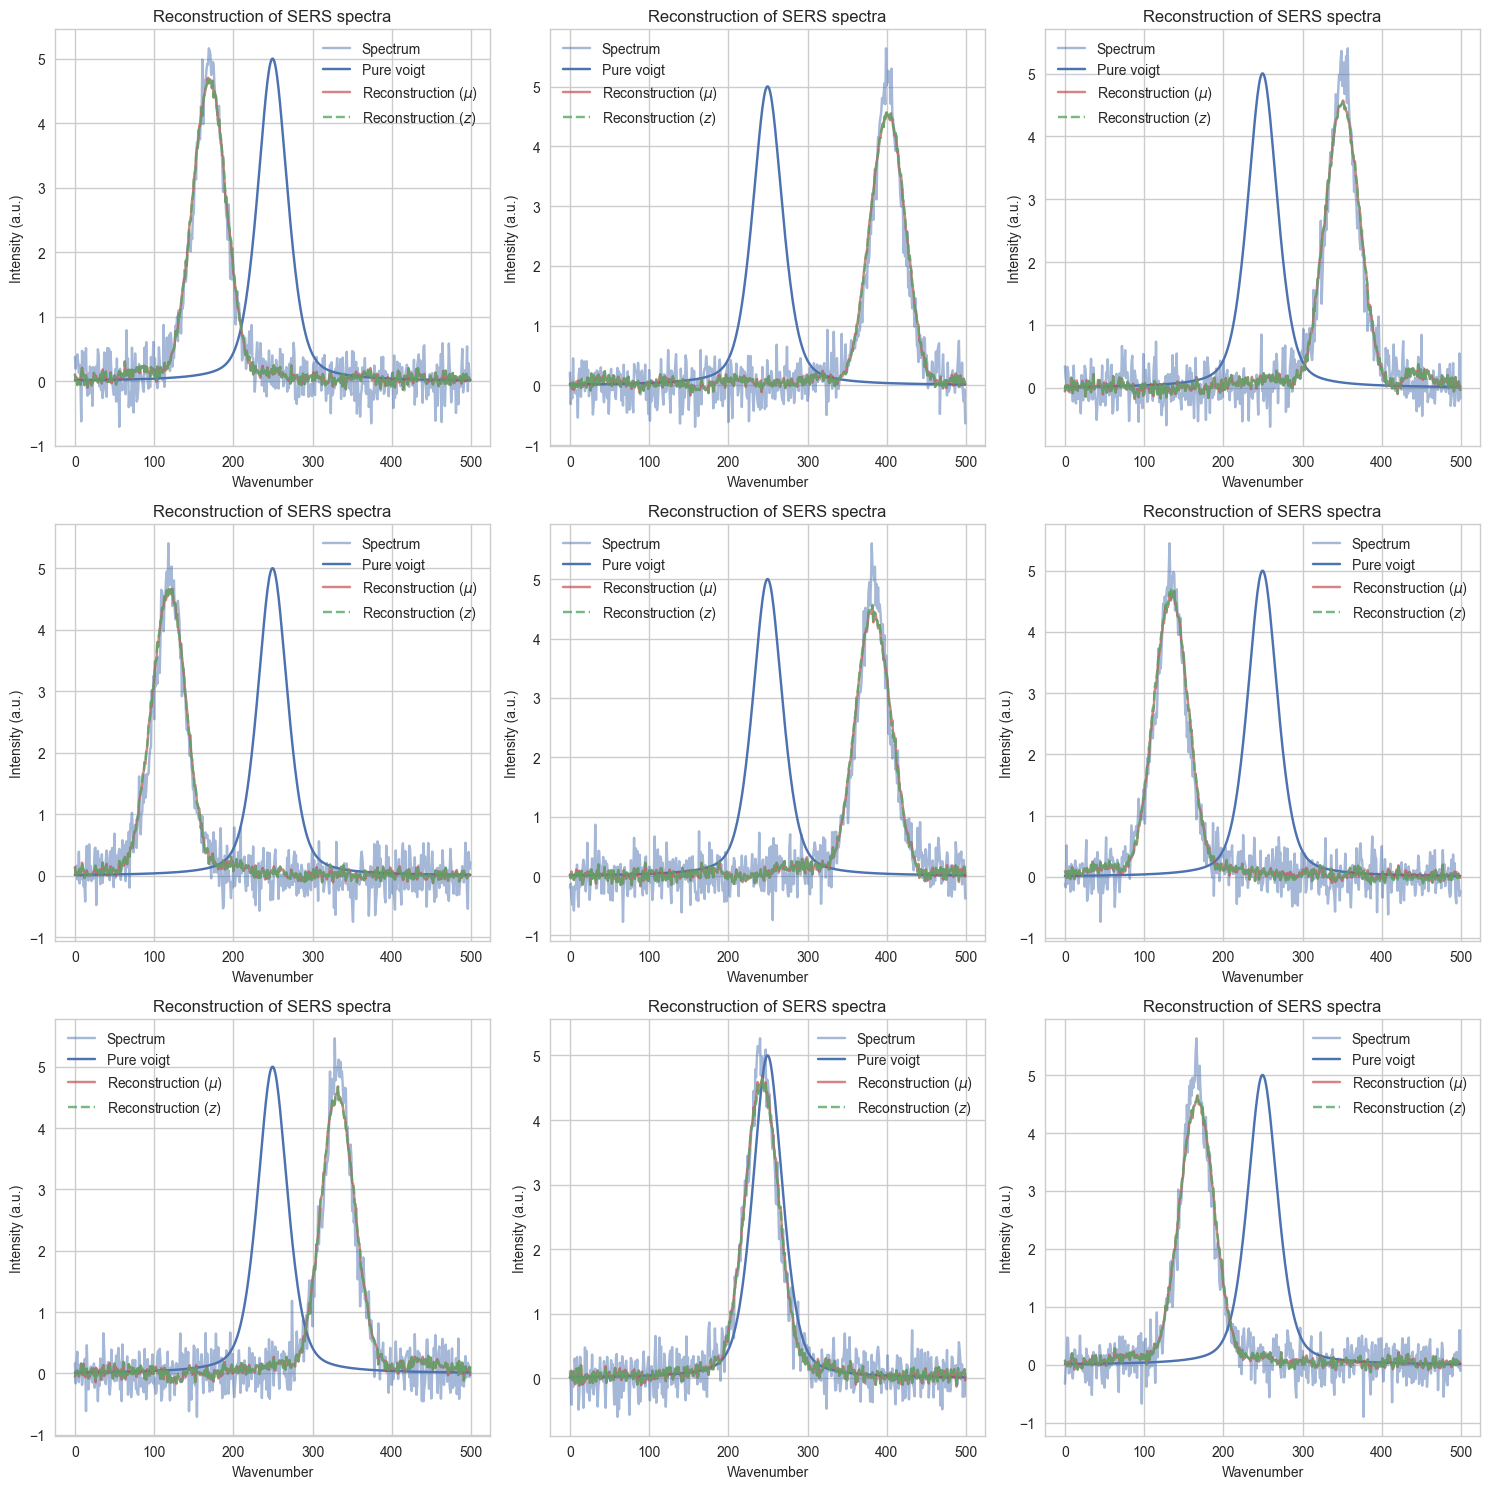

In [176]:
ps = pseudoVoigtSimulatorTorch(500)

def full_spec(x):
    return ps.generate_full_spectrum(peaks = torch.tensor([250]), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = x, sigma = 0, height_normalize=True, wavenumber_normalize=True)

x_ = x.to('cpu').detach().numpy()
x_hat_ = x_hat.to('cpu').detach().numpy()
x_hat_mu_ = x_hat_mu.to('cpu').detach().numpy()

plt_reconstructions(x_, x_hat_, x_hat_mu_, y[:,3], 3, full_spec)

# Varying $c$

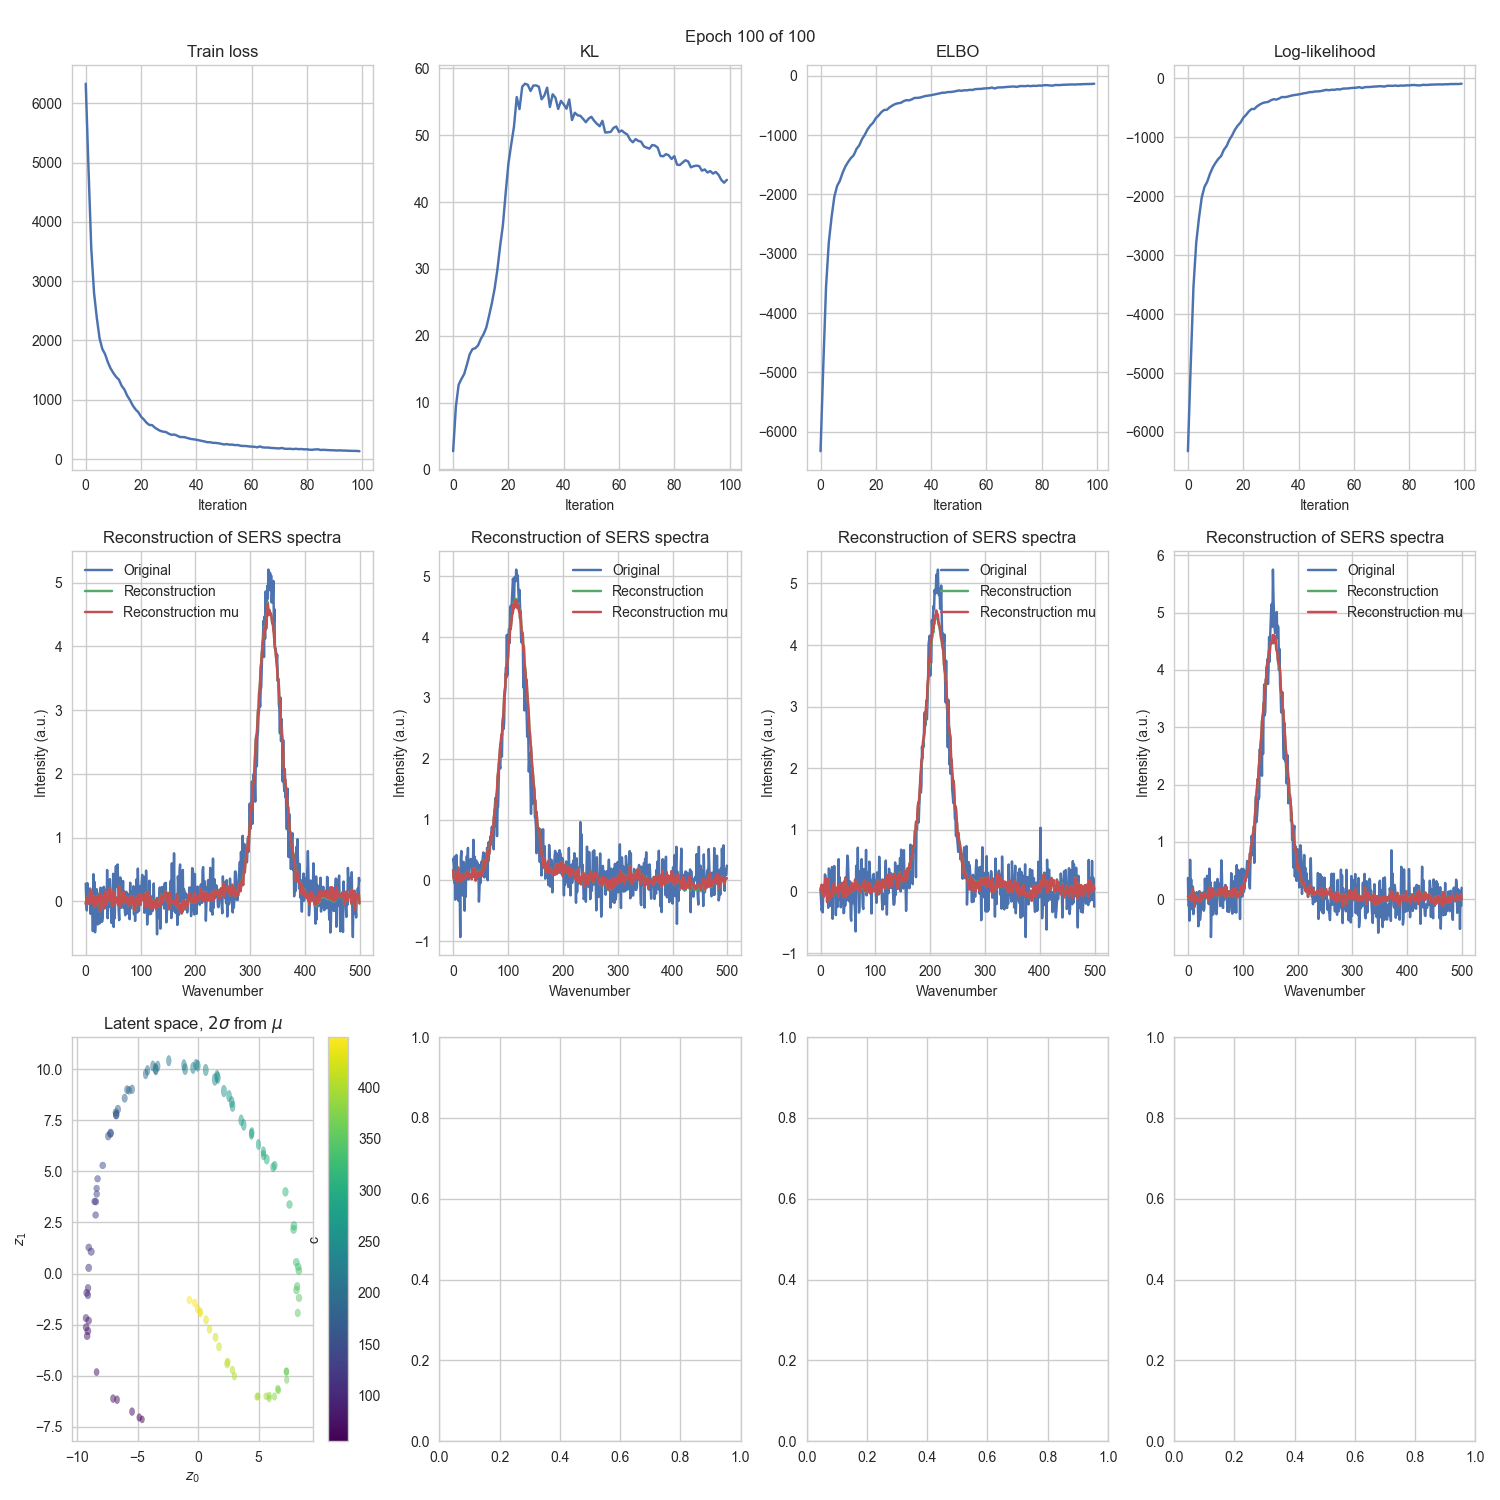

In [172]:
latent_dims = 2
epochs = 100
num_batches_per_epoch = 10
learning_rate = 1e-3
optimizer = "adam"
beta = 1


batch_size = 100
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.generator(1, peaks = (50,450), gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = torch.tensor([5]), sigma = 0.25)

dset_train = IterDataset(generator)

# Load the SERS dataset
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, pin_memory=cuda)

autoencoder = VariationalAutoencoder(next(iter(train_loader))[0][1].shape, latent_dims, batch_size, "c").to(device) 

#==============================================================================
# Train the model
#==============================================================================

autoencoder, train_loss = train(autoencoder, train_loader, 
                                        optimizer=optimizer, epochs=epochs, 
                                        num_iterations_per_epoch=num_batches_per_epoch,
                                        lr=learning_rate,beta=beta, label="c")


In [173]:
x , y = next(iter(train_loader))
x = x.to(device)
z, mu, logvar = autoencoder.encode(x)
x_hat = autoencoder.decode(z)
x_hat_mu = autoencoder.decode(mu)
sigma = torch.exp(0.5*logvar)
z = z.to('cpu').detach().numpy()
mu = mu.to('cpu').detach().numpy()
sigma = sigma.to('cpu').detach().numpy()

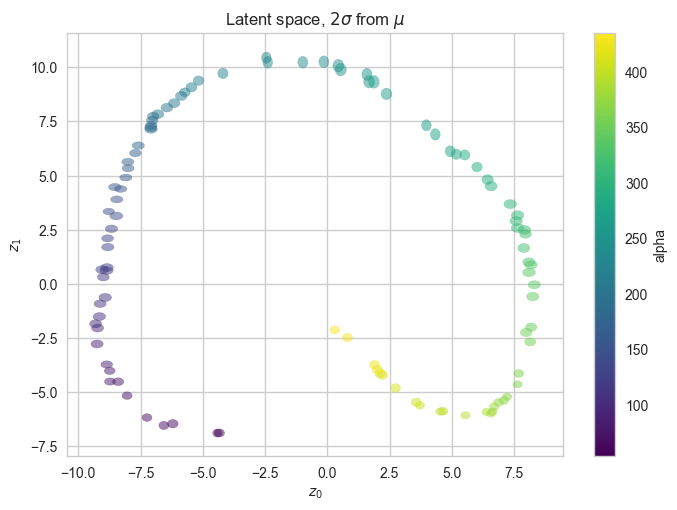

In [174]:
plt_latent_space_ellipses(z, mu, sigma, y[:,0].to('cpu').detach().numpy(), 'alpha')

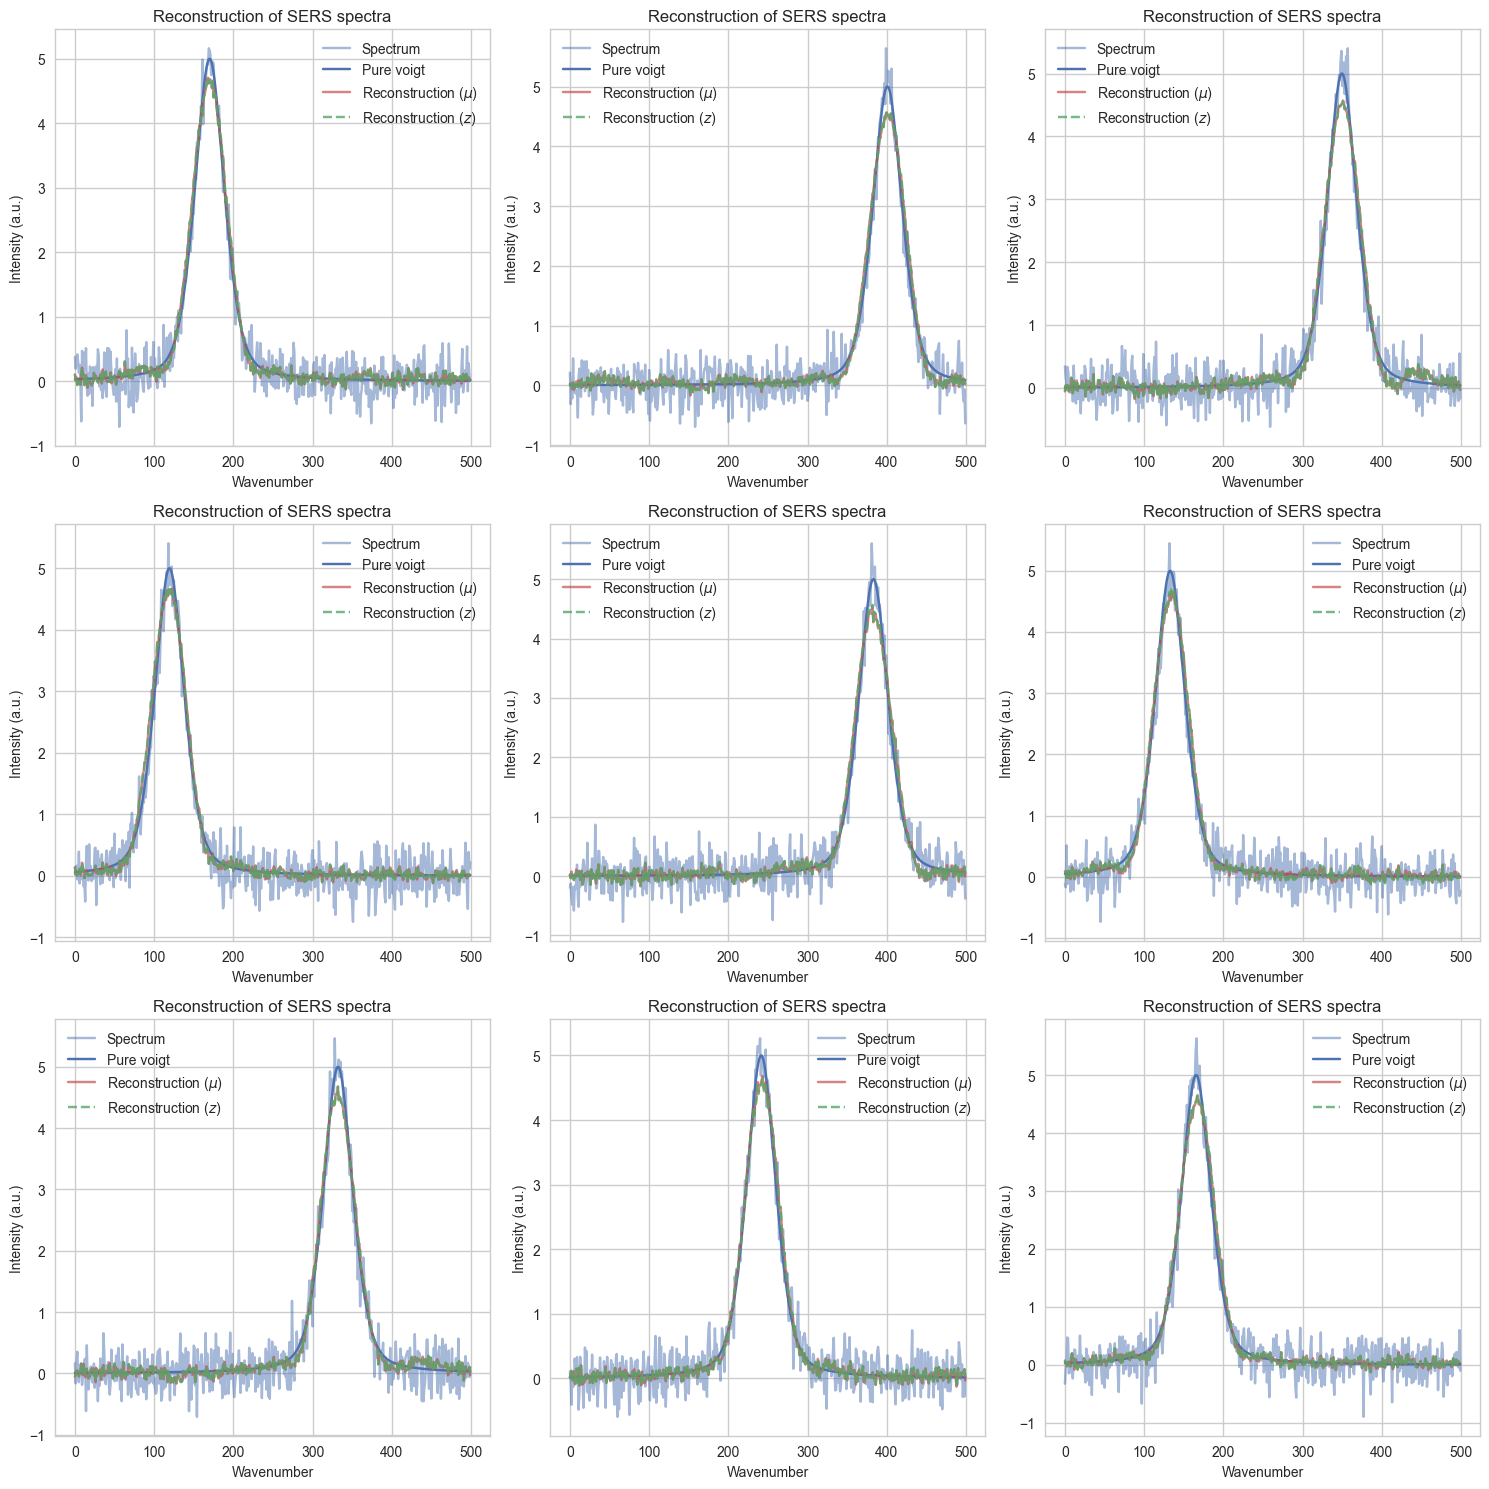

In [175]:
ps = pseudoVoigtSimulatorTorch(500)

def full_spec(x):
    return ps.generate_full_spectrum(peaks = x, gamma = torch.tensor([20]), eta = torch.tensor([0.5]), alpha = torch.tensor([5]), sigma = 0, height_normalize=True, wavenumber_normalize=True)

x_ = x.to('cpu').detach().numpy()
x_hat_ = x_hat.to('cpu').detach().numpy()
x_hat_mu_ = x_hat_mu.to('cpu').detach().numpy()

plt_reconstructions(x_, x_hat_, x_hat_mu_, y[:,0], 3, full_spec)

# Both